In [33]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import fsolve
import pandas as pd
import os

In [34]:
Theta = 20
M1 = [1.5, 2.0, 2.5] 
gamma = 1.4

In [35]:
def y(Theta, M1, gamma, beta):
    return (
        np.tan(Theta) - 2 * np.tan(beta)**(-1) * (
            M1**2 * np.sin(beta)**2 - 1
        ) / (
            M1**2 * (gamma + np.cos(2 * beta)) + 2
        )
    )

In [36]:
def Theta(beta, M1, gamma):
    return np.rad2deg(
            np.arctan(
            2 * np.tan(np.deg2rad(beta))**(-1) * (
                M1**2 * np.sin(np.deg2rad(beta))**2 - 1
            ) / (
                M1**2 * (gamma + np.cos(2 * np.deg2rad(beta))) + 2
            )
        )
    )

Theta(53, 2, 1.4)

19.78994896194563

In [37]:
def find_beta_for_theta(theta_target, M1, gamma, initial_guess=50):
    def f(beta):
        return Theta(beta, M1, gamma) - theta_target
    return fsolve(f, initial_guess)[0]

<>:41: SyntaxWarning: invalid escape sequence '\T'
<>:41: SyntaxWarning: invalid escape sequence '\T'
/var/folders/v_/5q1gkdc53z34pdsfnpkx2t340000gn/T/ipykernel_21192/2894658019.py:41: SyntaxWarning: invalid escape sequence '\T'
  plt.xlabel('Deflection Angle $\Theta$ [°]')


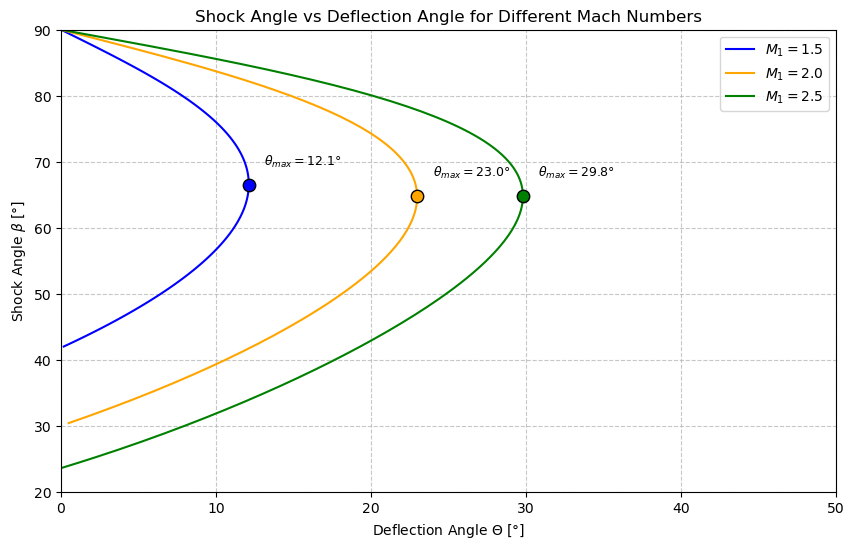

In [38]:
# Use a single beta range for all M1 values
beta_range = np.linspace(10, 90, 201)

# Calculate Theta values for each M1 value in M1_list
Theta_M = []
for M1_value in M1:
    Theta_M.append(Theta(beta_range, M1_value, gamma))

plt.figure(figsize=(10, 6))
colors = ['blue', 'orange', 'green']  # Colors for each M1 value
max_theta_vec = []

for i, (M1_value, Theta_) in enumerate(zip(M1, Theta_M)):
    # Filter out any invalid values and find the maximum Theta
    valid_mask = np.isfinite(Theta_) & (Theta_ >= 0)
    if np.any(valid_mask):
        # Find maximum deflection angle and its corresponding beta
        max_theta_idx = np.argmax(Theta_[valid_mask])
        max_theta = Theta_[valid_mask][max_theta_idx]
        max_theta_vec.append(max_theta)
        max_theta_beta = beta_range[valid_mask][max_theta_idx]
        
        # Plot the curve
        plt.plot(
            Theta_[valid_mask], beta_range[valid_mask], 
            color=colors[i], 
            label=f'$M_1={M1_value}$'
        )
        
        # Mark the maximum deflection point
        plt.scatter(
            max_theta, max_theta_beta, 
            color=colors[i], s=80, marker='o', 
            edgecolors='black', zorder=5
        )
        plt.annotate(f'$θ_{{max}}={max_theta:.1f}°$', 
                    xy=(max_theta, max_theta_beta),
                    xytext=(max_theta+1, max_theta_beta+3),
                    fontsize=9)

plt.xlabel('Deflection Angle $\Theta$ [°]')
plt.ylabel('Shock Angle $\\beta$ [°]')
plt.title('Shock Angle vs Deflection Angle for Different Mach Numbers')
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend(loc='best')
plt.xlim(0, 50)
plt.ylim(20, 90)
plt.savefig('Figures/M2_ThetaBeta.pdf', bbox_inches='tight')
plt.show()


In [39]:
def calc_Mn1(M1, beta):
    beta_ = np.deg2rad(beta)
    return M1 * np.sin(beta_)

def calc_Mn2(Mn1, gamma):
    return np.sqrt(
        (1 + ((gamma - 1) / 2) * Mn1**2) / (gamma * Mn1**2 - (gamma - 1) / 2)
    )

def calc_M2(Mn2, beta, theta):
    beta_ = np.deg2rad(beta)
    theta_ = np.deg2rad(theta)
    return Mn2 / np.sin(beta_ - theta_)

def calc_rho2rho1(Mn1, gamma):
    return (
        (gamma + 1) * Mn1**2 / (2 + (gamma - 1) * Mn1**2)
    )

def calc_p2p1(Mn1, gamma):
    return (
        1 + (2 * gamma / (gamma + 1)) * (Mn1**2 - 1)
    )

def calc_T2T1(Mn1, gamma):
    return calc_p2p1(Mn1, gamma) / calc_rho2rho1(Mn1, gamma)

In [40]:
# Define a vectorized version of find_beta_for_theta
def find_beta_vec(theta_target_array, M1_value, gamma, initial_guess=50):
    """
    Find beta values for an array of theta targets and a single M1 value.
    """
    beta_values = []
    for theta_target in theta_target_array:
        beta_values.append(find_beta_for_theta(theta_target, M1_value, gamma, initial_guess))
    return np.array(beta_values)

Theta_obj_vecs = [
    np.linspace(0, max_theta_vec[i], 201)
    for i in range(len(M1))
]
beta_values = []
for i in range(len(M1)):
    beta_values.append(
        find_beta_vec(Theta_obj_vecs[i], M1[i], gamma)
    )
Mn1, Mn2, M2_full, rho2rho1_full, p2p1_full, T2T1_full = [], [], [], [], [], []
for i, (M1_value, beta_values_) in enumerate(zip(M1, beta_values)):
    Mn1_current = calc_Mn1(M1_value, beta_values_)
    Mn1.append(Mn1_current)
    Mn2_current = calc_Mn2(Mn1_current, gamma)
    Mn2.append(Mn2_current)
    Theta_obj_vec = Theta_obj_vecs[i]
    M2_full.append(calc_M2(Mn2_current, beta_values_, Theta_obj_vec))
    rho2rho1_full.append(calc_rho2rho1(Mn1_current, gamma))
    p2p1_full.append(calc_p2p1(Mn1_current, gamma))
    T2T1_full.append(calc_T2T1(Mn1_current, gamma))

Theta_obj_vecs = np.array(Theta_obj_vecs)
Mn1 = np.array(Mn1)
Mn2 = np.array(Mn2)
M2_full = np.array(M2_full)
rho2rho1_full = np.array(rho2rho1_full)
p2p1_full = np.array(p2p1_full)
T2T1_full = np.array(T2T1_full)

In [41]:
Theta_obj_vecs.shape,M2_full.shape

((3, 201), (3, 201))

<>:11: SyntaxWarning: invalid escape sequence '\T'
<>:13: SyntaxWarning: invalid escape sequence '\T'
<>:15: SyntaxWarning: invalid escape sequence '\T'
<>:17: SyntaxWarning: invalid escape sequence '\T'
<>:11: SyntaxWarning: invalid escape sequence '\T'
<>:13: SyntaxWarning: invalid escape sequence '\T'
<>:15: SyntaxWarning: invalid escape sequence '\T'
<>:17: SyntaxWarning: invalid escape sequence '\T'
/var/folders/v_/5q1gkdc53z34pdsfnpkx2t340000gn/T/ipykernel_21192/1999641590.py:11: SyntaxWarning: invalid escape sequence '\T'
  axs[0, 0].set_xlabel('$\Theta$ (degrees)')
/var/folders/v_/5q1gkdc53z34pdsfnpkx2t340000gn/T/ipykernel_21192/1999641590.py:13: SyntaxWarning: invalid escape sequence '\T'
  axs[0, 1].set_xlabel('$\Theta$ (degrees)')
/var/folders/v_/5q1gkdc53z34pdsfnpkx2t340000gn/T/ipykernel_21192/1999641590.py:15: SyntaxWarning: invalid escape sequence '\T'
  axs[1, 0].set_xlabel('$\Theta$ (degrees)')
/var/folders/v_/5q1gkdc53z34pdsfnpkx2t340000gn/T/ipykernel_21192/1999641590.

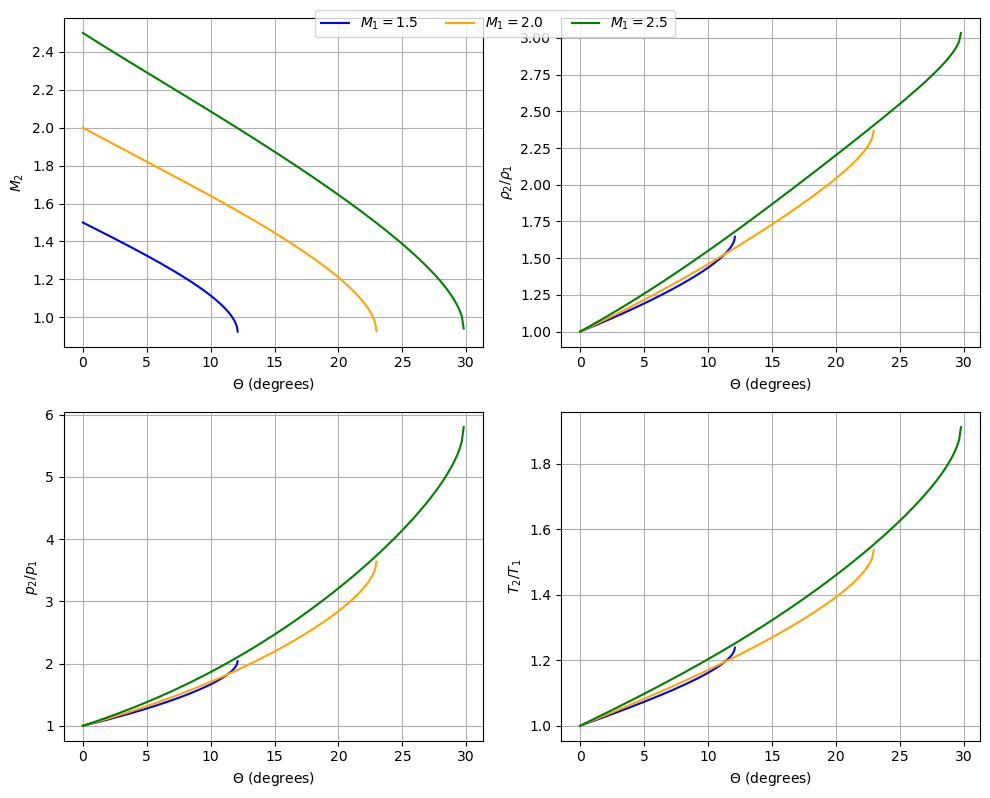

In [42]:
fig, axs = plt.subplots(2, 2, figsize=(10, 8))

Theta_obj_vecs = np.array(Theta_obj_vecs)
for i, M1_value in enumerate(M1):
	axs[0, 0].plot(Theta_obj_vecs[i,:], M2_full[i,:], color=colors[i], label=f'$M_1={M1[i]}$')
	axs[0, 1].plot(Theta_obj_vecs[i,:], rho2rho1_full[i,:], color=colors[i])
	axs[1, 0].plot(Theta_obj_vecs[i,:], p2p1_full[i,:], color=colors[i])
	axs[1, 1].plot(Theta_obj_vecs[i,:], T2T1_full[i,:], color=colors[i])

# Set labels for each subplot
axs[0, 0].set_xlabel('$\Theta$ (degrees)')
axs[0, 0].set_ylabel('$M_2$')
axs[0, 1].set_xlabel('$\Theta$ (degrees)')
axs[0, 1].set_ylabel('$\\rho_2/\\rho_1$')
axs[1, 0].set_xlabel('$\Theta$ (degrees)')
axs[1, 0].set_ylabel('$p_2/p_1$')
axs[1, 1].set_xlabel('$\Theta$ (degrees)')
axs[1, 1].set_ylabel('$T_2/T_1$')

# Add a legend to the figure
handles, labels = axs[0, 0].get_legend_handles_labels()
fig.legend(handles, labels, loc='upper center', bbox_to_anchor=(0.5, 1.0), ncol=3)

# Turn on grid for all subplots
for ax in axs.flatten():
	ax.grid(True)

plt.tight_layout()
plt.show()

In [43]:
# Loop over different geometries
folder = []
Setups = []
y_height = []
for foldername in os.listdir('results'):
    if os.path.isdir(os.path.join('results', foldername)):
        folder.append(f'results/{foldername}/touch.case')
        Setups.append(foldername)
        y_height.append(float(foldername.split('_')[1].split('m')[0]))
csv_files = [f'Figures/{setup}/lineplot.csv' for setup in Setups]
df_shock = [pd.read_csv(csv_file) for csv_file in csv_files]

# Properties
properties = ['Ma', 'T', 'p', 'U', 'rho']

In [44]:
# Extract Mach numbers and angles from Setups
mach_numbers = [float(setup.split('_')[0][1:]) for setup in Setups]
angles_rad = [float(setup.split('_')[1]) for setup in Setups]
angles_deg = [np.rad2deg(float(angle)) for angle in angles_rad]

# Get numerical results (last point of each dataframe)
numerical_results = {
    'Ma': [df['Ma'].values[-1] for df in df_shock],
    'T': [df['T'].values[-1] for df in df_shock],
    'p': [df['p'].values[-1] for df in df_shock],
    'rho': [df['rho'].values[-1] for df in df_shock]
}

# # Calculate analytical results for each Mach number and wedge angle
# analytical_results = {
#     'Ma': [], 'T': [], 'p': [], 'rho': []
# }

# for i, (m, angle) in enumerate(zip(mach_numbers, angles_deg)):
#     beta = find_beta_for_theta(angle, m, gamma)
#     Mn1 = calc_Mn1(m, beta)
#     Mn2 = calc_Mn2(Mn1, gamma)
#     M2 = calc_M2(Mn2, beta, angle)
#     rho2rho1 = calc_rho2rho1(Mn1, gamma)
#     p2p1 = calc_p2p1(Mn1, gamma)
#     T2T1 = calc_T2T1(Mn1, gamma)
    
#     analytical_results['Ma'].append(M2)
#     analytical_results['T'].append(300 * T2T1)  # Assuming T1 = 300K
#     analytical_results['p'].append(101325 * p2p1)  # Assuming p1 = 101325 Pa
#     analytical_results['rho'].append(1.174 * rho2rho1)  # Assuming rho1 = 1.174 kg/m³

# # Plot results
# fig, axs = plt.subplots(2, 2, figsize=(12, 10))
# properties = ['Ma', 'T', 'p', 'rho']
# titles = ['(a) Mach Number', '(b) Temperature [K]', '(c) Pressure [Pa]', '(d) Density [kg/m³]']

# # Map Mach numbers to unique line styles
# unique_machs = sorted(list(set(mach_numbers)))
# line_styles = ['-', '--', '-.']
# mach_to_style = {m: style for m, style in zip(unique_machs, line_styles)}

# # Map angles to unique colors using a colormap
# unique_angles = sorted(list(set(angles_deg)))
# cmap = plt.cm.viridis
# angle_to_color = {angle: cmap(i/len(unique_angles)) for i, angle in enumerate(unique_angles)}

# for i, (prop, title) in enumerate(zip(properties, titles)):
#     row, col = i // 2, i % 2
    
#     # Plot points
#     for j, (m, angle) in enumerate(zip(mach_numbers, angles_deg)):
#         axs[row, col].scatter(
#             analytical_results[prop][j], 
#             numerical_results[prop][j],
#             marker='o',
#             color=angle_to_color[angle],
#             s=100,
#             label=f'M={m}, θ={angle:.1f}°' if j < len(unique_machs) * len(unique_angles) else ""
#         )
    
#     # Add reference line (y=x)
#     min_val = min(min(analytical_results[prop]), min(numerical_results[prop]))
#     max_val = max(max(analytical_results[prop]), max(numerical_results[prop]))
#     padding = 0.1 * (max_val - min_val)
#     axs[row, col].plot([min_val-padding, max_val+padding], [min_val-padding, max_val+padding], 'k--')
    
#     axs[row, col].set_xlabel(f'Analytical {prop}')
#     axs[row, col].set_ylabel(f'Numerical {prop}')
#     axs[row, col].set_title(title)
#     axs[row, col].grid(True)

# # Create a unified legend outside the plots
# handles, labels = [], []
# for m in unique_machs:
#     h, = plt.plot([], [], mach_to_style[m], color='black', label=f'M={m}')
#     handles.append(h)
#     labels.append(f'M={m}')

# for angle in unique_angles:
#     h = plt.scatter([], [], color=angle_to_color[angle], s=50)
#     handles.append(h)
#     labels.append(f'θ={angle:.1f}°')

# fig.legend(handles, labels, loc='upper center', bbox_to_anchor=(0.5, 1.05), ncol=len(handles))
# plt.tight_layout()
# plt.subplots_adjust(top=0.85)  # Make room for the legend
# plt.show()

In [45]:
# Inflow
M1 = 2.
T1 = 300.
p1 = 101325.
rho1 = 1.174

In [46]:
M2_full.shape, rho2rho1_full.shape, p2p1_full.shape, T2T1_full.shape

((3, 201), (3, 201), (3, 201), (3, 201))

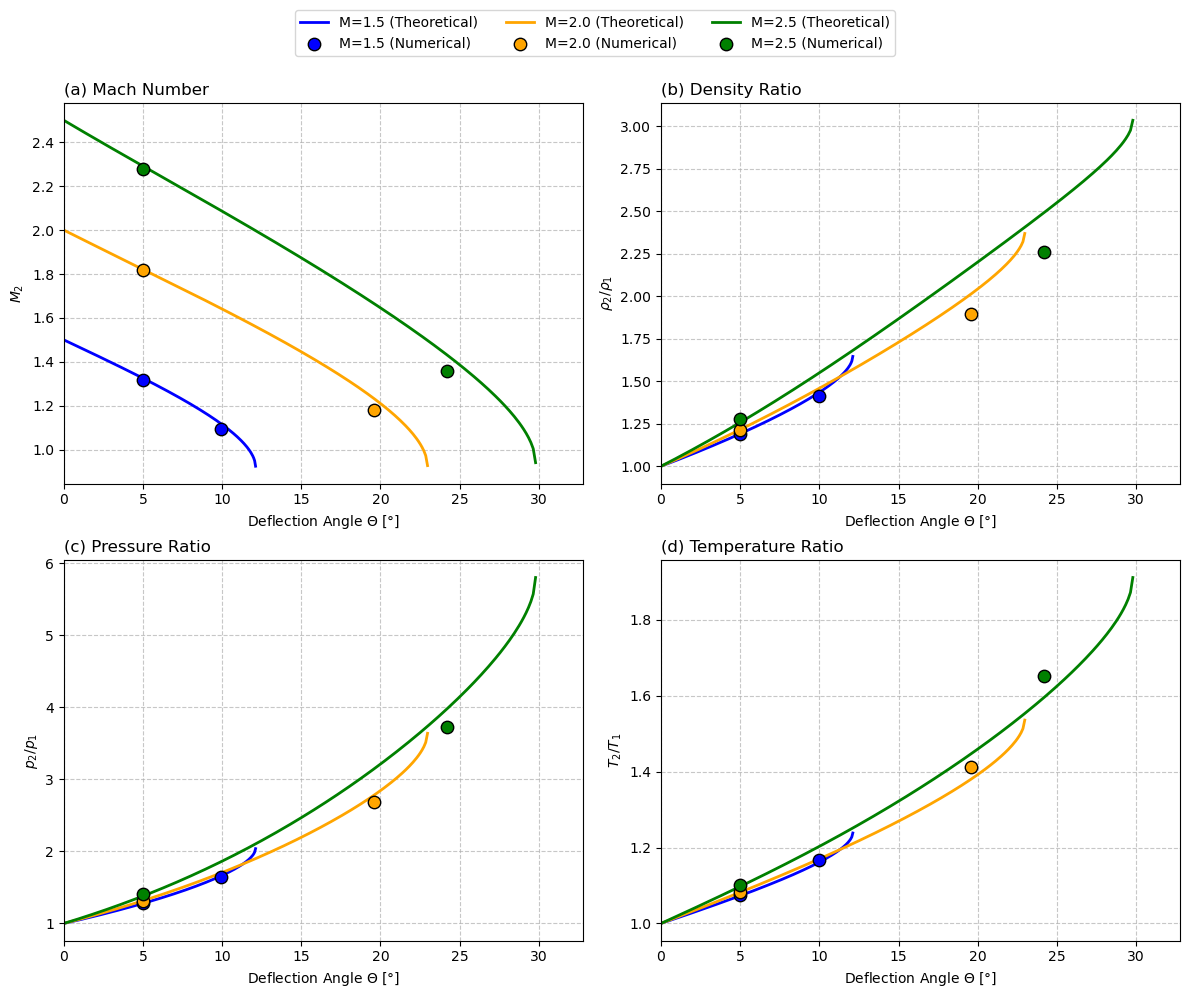

In [47]:
# Restore M1 as the original list since it was redefined as a float in cell 12
M1 = [1.5, 2.0, 2.5] 

# Create a 2x2 plot for all Mach numbers
fig, axs = plt.subplots(2, 2, figsize=(12, 10))

# Data to plot
properties = ['Mach Number', 'Density Ratio', 'Pressure Ratio', 'Temperature Ratio']
theoretical_data = [M2_full, rho2rho1_full, p2p1_full, T2T1_full]
y_labels = ['$M_2$', '$\\rho_2/\\rho_1$', '$p_2/p_1$', '$T_2/T_1$']
titles = ['(a)', '(b)', '(c)', '(d)']

# Use different colors for each Mach number
colors = ['blue', 'orange', 'green']
for i, (prop, theor_data, ylabel, title) in enumerate(zip(properties, theoretical_data, y_labels, titles)):
    row, col = i // 2, i % 2
    
    # Plot theoretical curves for each Mach number
    for m_idx, m_value in enumerate(M1):
        # Plot theoretical curve using the corresponding Theta_obj_vecs for this Mach number
        axs[row, col].plot(
            Theta_obj_vecs[m_idx], theor_data[m_idx], 
            color=colors[m_idx], linewidth=2, 
            label=f'M={m_value} (Theoretical)'
        )
        
        # Find numerical data for this Mach number
        m_indices = [j for j, m in enumerate(mach_numbers) if m == m_value]
        
        if m_indices:
            # Get numerical data for this Mach number
            thetas = [angles_deg[j] for j in m_indices]
            
            if prop == 'Mach Number':
                values = [numerical_results['Ma'][j] for j in m_indices]
            elif prop == 'Density Ratio':
                values = [numerical_results['rho'][j]/rho1 for j in m_indices]
            elif prop == 'Pressure Ratio':
                values = [numerical_results['p'][j]/p1 for j in m_indices]
            else:  # Temperature Ratio
                values = [numerical_results['T'][j]/T1 for j in m_indices]
            
            # Plot numerical points
            axs[row, col].scatter(thetas, values, color=colors[m_idx], 
                                marker='o', s=80, edgecolors='black', 
                                zorder=3, label=f'M={m_value} (Numerical)')
    
    axs[row, col].set_xlabel('Deflection Angle $\\Theta$ [°]')
    axs[row, col].set_ylabel(ylabel)
    axs[row, col].set_title(f'{title} {prop}', loc='left')
    axs[row, col].grid(True, linestyle='--', alpha=0.7)
    
    # Set reasonable x-axis limits
    max_theta = max([max(angles_deg), max([max(tv) for tv in Theta_obj_vecs])])
    axs[row, col].set_xlim(0, max_theta * 1.1)

# Create a clean legend with unique entries
handles, labels = [], []
for m_idx, m_value in enumerate(M1):
    # Theoretical line
    h1, = plt.plot([], [], color=colors[m_idx], linewidth=2)
    handles.append(h1)
    labels.append(f'M={m_value} (Theoretical)')
    
    # Numerical points
    h2 = plt.scatter([], [], color=colors[m_idx], marker='o', s=80, edgecolors='black')
    handles.append(h2)
    labels.append(f'M={m_value} (Numerical)')

fig.legend(handles, labels, loc='upper center', bbox_to_anchor=(0.5, 1.0), ncol=3)

plt.tight_layout()
plt.subplots_adjust(top=0.9)  # Make room for the legend
plt.savefig('Figures/CompareAnalyticalNumerical.pdf', bbox_inches='tight')
plt.show()